In [3]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
subm = pd.read_csv('sample_submission.csv')

In [5]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [7]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.0732213246768, 590.7202819048923, 5000)

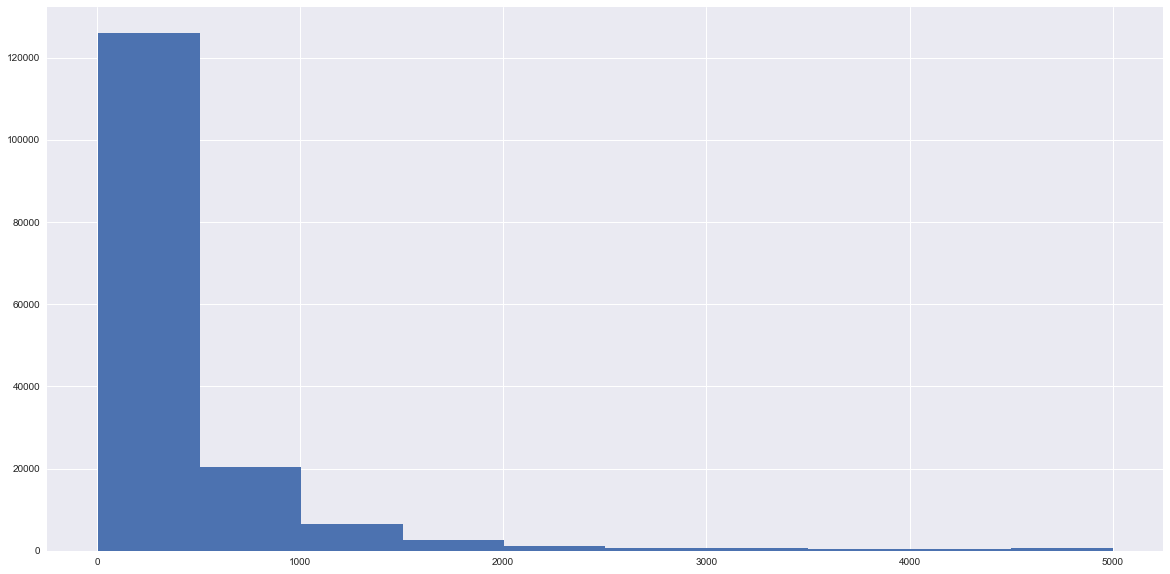

In [8]:
sns.set_style("white")
sns.set(rc={"figure.figsize": (20, 10)})
lens.hist();

In [9]:
lens

0          264
1          112
2          233
3          622
4           67
5           65
6           44
7          115
8          472
9           70
10        2875
11          56
12         319
13         819
14         219
15         610
16          57
17          48
18         118
19         440
20         266
21          58
22         543
23          97
24        1409
25         172
26         288
27         343
28         119
29          78
          ... 
159541     346
159542     164
159543      80
159544      19
159545     105
159546     534
159547      30
159548      27
159549      25
159550     173
159551     196
159552      92
159553     888
159554     182
159555     119
159556      57
159557     429
159558     134
159559     357
159560    1889
159561    1147
159562    1015
159563     394
159564     369
159565     653
159566     295
159567      99
159568      81
159569     116
159570     189
Name: comment_text, Length: 159571, dtype: int64

In [10]:
label_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
train['none']=1-train[label_cols].max(axis=1)
# train['none'] = 1
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [12]:
train['comment_text'].fillna('unknow', inplace=True)
test['comment_text'].fillna('unknow', inplace=True)

In [13]:
import re, string

In [14]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokensize(s):
    return re_tok.sub(r' \1', s).split()

In [15]:
n = train.shape[0]

In [16]:
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokensize,
                      min_df=3, max_df=0.9, strip_accents='unicode',
                     use_idf=1, smooth_idf=1, sublinear_tf=1)
train_term_doc = vec.fit_transform(train['comment_text'])


In [17]:
test_term_doc = vec.transform(test['comment_text'])
train_term_doc, test_term_doc

(<159571x435399 sparse matrix of type '<class 'numpy.float64'>'
 	with 17017600 stored elements in Compressed Sparse Row format>,
 <153164x435399 sparse matrix of type '<class 'numpy.float64'>'
 	with 14036758 stored elements in Compressed Sparse Row format>)

In [18]:
#朴素贝叶斯
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [19]:
x = train_term_doc
test_x = test_term_doc

In [20]:
#一次一个依赖项拟合模型
def get_dml(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [21]:
import numpy as np
preds = np.zeros((len(test), len(label_cols)))
for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_dml(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]
    print(r)

fit toxic
[[1.17228421 2.10002287 2.42464012 ... 1.78887928 0.81849305 0.81849305]]
fit severe_toxic
[[1.38473629 2.25153136 3.86895525 ... 3.65863776 3.16922599 3.16922599]]
fit obscene
[[1.14070584 1.9721919  2.79431691 ... 1.94761644 1.45820467 1.45820467]]
fit threat
[[1.29005516 1.98092565 4.43288741 ... 4.86923871 4.37982694 4.37982694]]
fit insult
[[1.13948458 1.91815666 2.80189437 ... 2.02148667 1.5320749  1.5320749 ]]
fit identity_hate
[[1.06978712 1.84015559 3.7017714  ... 3.78659145 3.29717968 3.29717968]]


In [22]:
submid = pd.DataFrame({'id': subm['id']})
submission = pd.concat([submid, pd.DataFrame(preds, columns=label_cols)], axis=1)
submission.to_csv('submission.csv', index=False)